## Anomaly detection - Time series
### Artificially generated data from NAB - CNN autoencoder

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>

<div style="text-align: right\"> Initial upload: 2020.12.29 </div>
<div style="text-align: right\"> Last update: 2020.12.29</div>

NAB의 Univerate time series 데이터를 사용한다.  
1D CNN 기반 Autoencoder를 사용한 이상탐지 기법을 살펴본다.

- 참고자료 : https://keras.io/examples/timeseries/timeseries_anomaly_detection/  
- 참고자료 : https://www.kaggle.com/boltzmannbrain/nab  
- 참고자료 : https://github.com/numenta/NAB  
- 참고자료 : https://jaehyeongan.github.io/2020/02/29/LSTM-Autoencoder-for-Anomaly-Detection/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#e3120b', '#4a4a4a', 
          '#111D5E', '#9F5F80', '#A7C5EB', '#54E346', '#FD3A69']
sns.color_palette(colors)

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.06666666666666667, 0.11372549019607843, 0.3686274509803922),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.6549019607843137, 0.7725490196078432, 0.9215686274509803),
 (0.32941176470588235, 0.8901960784313725, 0.27450980392156865),
 (0.9921568627450981, 0.22745098039215686, 0.4117647058823529)]

### 1. 데이터 읽기

[Numenta Anomaly Benchmark(NAB)](https://www.kaggle.com/boltzmannbrain/nab) 데이터셋을 사용한다.  
여기서 art_daily_small_noise.csv 파일을 학습에 art_daily_jumpsup.csv 파일을 시험에 사용한다.

In [3]:
df_small_noise_url = './data/NAB/artificialNoAnomaly/art_daily_small_noise.csv'
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates = True, 
                             index_col= 'timestamp')

df_daily_jumpsup_url = './data/NAB/artificialWithAnomaly/art_daily_jumpsup.csv'
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates = True,
                              index_col = 'timestamp')

In [4]:
display(df_small_noise.head())
display(df_daily_jumpsup.head())

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [5]:
df_small_noise.shape

(4032, 1)

In [6]:
df_daily_jumpsup.shape

(4032, 1)

- 데이터는 5분 주기로 취득된다.  
- 따라서 하루에 288개가 취득된다.(24*60/5)  
- 따라서 14일간의 데이터가 취득 된 것이다.(4032/288) 

데이터 시각화

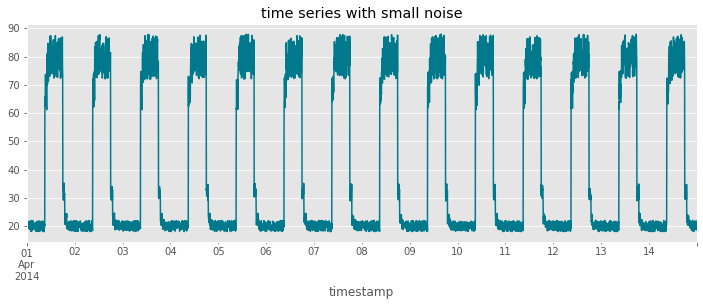

In [7]:
fig, ax = plt.subplots(figsize = (12, 4))
df_small_noise.plot(ax = ax, color = colors[0], legend = False)
plt.title('time series with small noise')
plt.show()

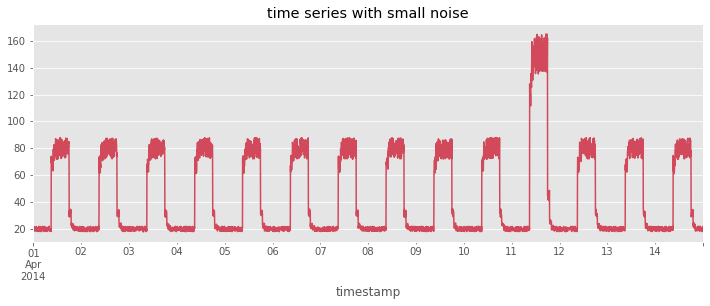

In [8]:
fig, ax = plt.subplots(figsize = (12, 4))
df_daily_jumpsup.plot(ax = ax, color = colors[1], legend = False)
plt.title('time series with small noise')
plt.show()

### 2. 데이터 준비

데이터 정규화

In [9]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

df_training_value = (df_small_noise - training_mean)/training_std

In [10]:
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


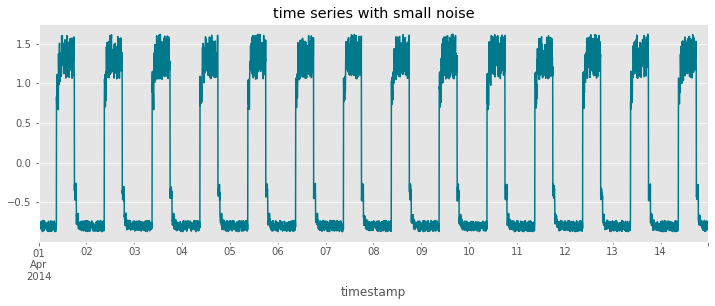

In [11]:
fig, ax = plt.subplots(figsize = (12, 4))
df_training_value.plot(ax = ax, color = colors[0], legend = False)
plt.title('time series with small noise')
plt.show()

학습용 시퀀스 만들기  
여기서는 하루치 샘플 288개를 기본단위로 하는 시퀀스를 만든다.

In [12]:
TIME_STEPS = 288

In [13]:
def create_sequences(values, time_steps = TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.array(output)

In [14]:
X_train = create_sequences(df_training_value.values)

In [15]:
X_train.shape

(3744, 288, 1)

### 3. 모델 생성하기

입력피처의 shape는 (sequence length, numfeatures) 이다.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Conv1D, Conv1DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters = 32, kernel_size = 7, padding = 'same', strides = 2,
                activation = 'relu'))
model.add(Dropout(rate = 0.2))
model.add(Conv1D(filters = 16, kernel_size = 7, padding = 'same', strides = 2,
                activation = 'relu'))
model.add(Conv1DTranspose(filters = 16, kernel_size = 7, padding = 'same',
                         strides = 2, activation = 'relu'))
model.add(Dropout(rate = 0.2))
model.add(Conv1DTranspose(filters = 32, kernel_size = 7, padding = 'same',
                         strides = 2, activation = 'relu'))
model.add(Conv1DTranspose(filters = 1, kernel_size = 7, padding = 'same'))

In [18]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

### 4. 모델 학습

In [20]:
callbacks = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min')

In [21]:
# history = model.fit(X_train, X_train, epochs = 50, batch_size = 128,
#                    validation_split= 0.1, callbacks = callbacks)

history = model.fit(X_train, X_train, epochs = 50, batch_size = 128,
                   validation_split= 0.1)

Epoch 1/50
27/27 [==============================] - 1s 21ms/step - loss: 0.5272 - val_loss: 0.0502
Epoch 2/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0776 - val_loss: 0.0413
Epoch 3/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0558 - val_loss: 0.0339
Epoch 4/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0469 - val_loss: 0.0300
Epoch 5/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0410 - val_loss: 0.0270
Epoch 6/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0363 - val_loss: 0.0261
Epoch 7/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0321 - val_loss: 0.0246
Epoch 8/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0285 - val_loss: 0.0259
Epoch 9/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0258 - val_loss: 0.0250
Epoch 10/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0239 - val_loss: 0.0259
Epoch 11/50
27/27 

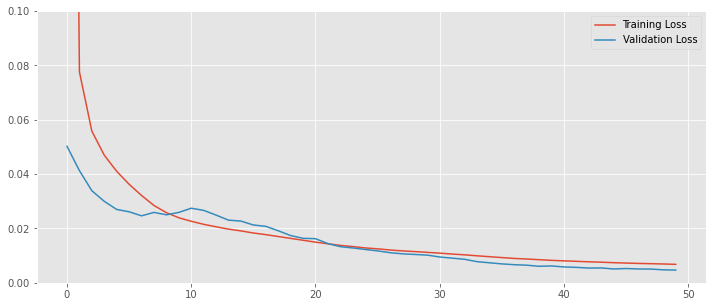

In [22]:
plt.figure(figsize = (12, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylim([0, 0.1])
plt.legend()
plt.show()

### 5. 이상탐지

1. 학습데이터에서 MAE 계산  
2. 최대 MAE 값을 찾고 이 값을 worst reconstruction error = threshold로 설정  
3. 시험데이터에서 recon error가 threshold를 초과하면 이상 값으로 판정

In [23]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis = 1)

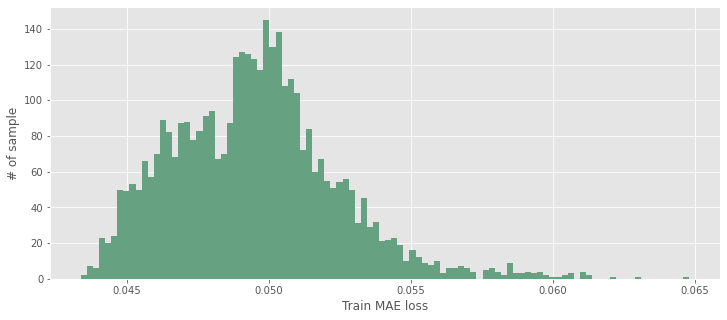

In [24]:
plt.figure(figsize = (12, 5))
plt.hist(train_mae_loss, bins = 100, color = colors[3])
plt.xlabel('Train MAE loss')
plt.ylabel('# of sample')
plt.show()

In [25]:
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.06479882893200178


reconstruction 비교

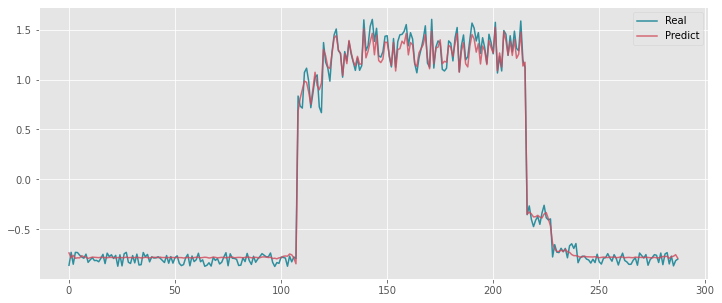

In [26]:
plt.figure(figsize = (12, 5))
plt.plot(X_train[0], color = colors[0], alpha = 0.8, label = 'Real')
plt.plot(X_train_pred[0], color = colors[1], alpha = 0.8, label = 'Predict')
plt.legend()
plt.show()

시험데이터 준비

In [27]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

In [28]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std

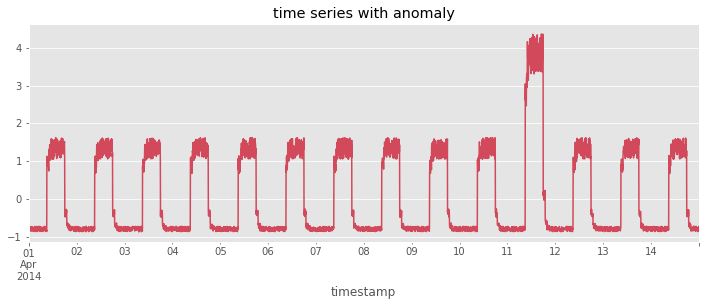

In [29]:
fig, ax = plt.subplots(figsize = (12, 4))
df_test_value.plot(ax = ax, color = colors[1], legend = False)
plt.title('time series with anomaly')
plt.show()

In [30]:
X_test = create_sequences(df_test_value.values)
print("Test input shape: ", X_test.shape)

Test input shape:  (3744, 288, 1)


In [31]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [32]:
test_mae_loss

array([[0.04957012],
       [0.04841287],
       [0.04984968],
       ...,
       [0.04979365],
       [0.05216656],
       [0.0512506 ]])

In [33]:
test_mae_loss = test_mae_loss.reshape((-1))

In [34]:
test_mae_loss

array([0.04957012, 0.04841287, 0.04984968, ..., 0.04979365, 0.05216656,
       0.0512506 ])

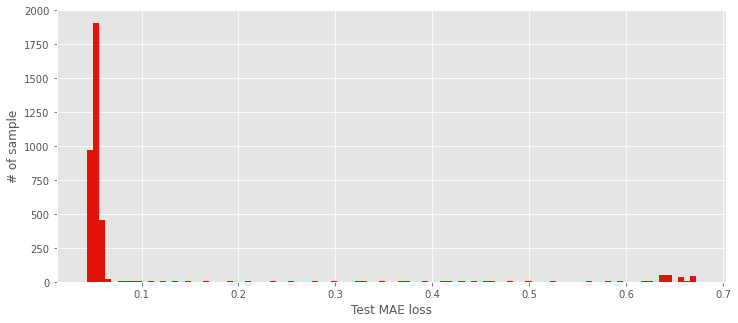

In [35]:
plt.figure(figsize = (12, 5))
plt.hist(test_mae_loss, bins = 100, color = colors[4])
plt.xlabel('Test MAE loss')
plt.ylabel('# of sample')
plt.show()

In [36]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  405
Indices of anomaly samples:  (array([ 792,  793,  794, 1657, 1945, 2521, 2522, 2701, 2702, 2703, 2704,
       2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715,
       2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726,
       2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2

### 6. 이상치 차트 그리기

time steps가 3인 경유 예를 들어보자. 데이터셋이 다음과 같이 생겼을 것이다.  
- 0, 1, 2  
- 1, 2, 3  
- 2, 3, 4  
- 3, 4, 5  
- 4, 5, 6  
그리고 예를 들어 (3, 4, 5), (4, 5, 6), (5, 6, 7)이 이상 샘플인 것으로 확인되었다면 point5가 이상인 것으로 알수가 있을 것이다.

**즉 ((i - timestps + 1)) 부터 (i) 번째 까지 샘플이 이상이면 i번째 데이터가 이상인 것으로 판정한다.**

In [37]:
anomalous_data_indices = []
for data_idx in range (TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [38]:
anomalous_data_indices

[2988,
 2989,
 2990,
 2991,
 2992,
 2993,
 2994,
 2995,
 2996,
 2997,
 2998,
 2999,
 3000,
 3001,
 3002,
 3003,
 3004,
 3005,
 3006,
 3007,
 3008,
 3009,
 3010,
 3011,
 3012,
 3013,
 3014,
 3015,
 3016,
 3017,
 3018,
 3019,
 3020,
 3021,
 3022,
 3023,
 3024,
 3025,
 3026,
 3027,
 3028,
 3029,
 3030,
 3031,
 3032,
 3033,
 3034,
 3035,
 3036,
 3037,
 3038,
 3039,
 3040,
 3041,
 3042,
 3043,
 3044,
 3045,
 3046,
 3047,
 3048,
 3049,
 3050,
 3051,
 3052,
 3053,
 3054,
 3055,
 3056,
 3057,
 3058,
 3059,
 3060,
 3061,
 3062,
 3063,
 3064,
 3065,
 3066,
 3067,
 3068,
 3069,
 3070,
 3071,
 3072,
 3073,
 3074,
 3075,
 3076,
 3077,
 3078,
 3079,
 3080,
 3081,
 3082,
 3083,
 3084,
 3085,
 3086,
 3087,
 3088,
 3089,
 3090,
 3091,
 3092,
 3093,
 3094,
 3095,
 3096,
 3097,
 3098,
 3099]

In [39]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]

In [40]:
df_subset

,value
timestamp,
2014-04-11 09:00:00,127.882020
2014-04-11 09:05:00,115.705719
2014-04-11 09:10:00,122.386410
2014-04-11 09:15:00,127.261178
2014-04-11 09:20:00,121.157997
...,...
2014-04-11 17:55:00,161.890865
2014-04-11 18:00:00,44.913766
2014-04-11 18:05:00,47.742574


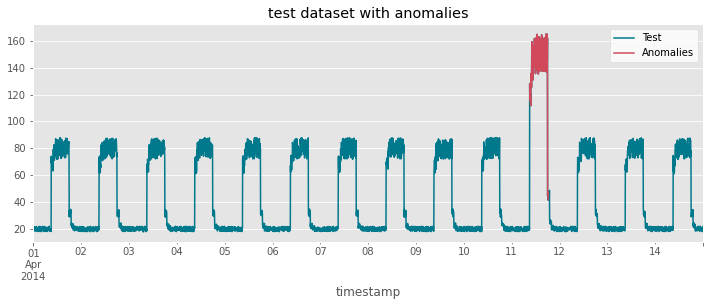

In [41]:
fig, ax = plt.subplots(figsize = (12, 4))
df_daily_jumpsup.plot(ax = ax, color = colors[0], label = 'Test')
df_subset.plot(ax = ax, color = colors[1], label = 'Anomalies')
plt.title('test dataset with anomalies')
plt.legend(['Test', 'Anomalies'], facecolor = 'white')
plt.show()